✅ Extracted black elements from captchas and saved them to 'black_text_only/'


In [1]:
path = "Captcha -20250613T230133Z-1-001\Preprocessed"

Loading data...
Loaded 218 valid CAPTCHA images
Sample image shape: (60, 160, 1) (height, width, channels)
Encoded labels shape: (218, 5)
Sample label: 00688 -> Encoded: [0 0 6 8 8]

Training model...
Epoch 1/150
6/6 [==============================] - 9s 1s/step - loss: 3.4181 - accuracy: 0.0989 - val_loss: 2.3044 - val_accuracy: 0.1318 - lr: 0.0010
Epoch 2/150
6/6 [==============================] - 7s 1s/step - loss: 2.8945 - accuracy: 0.1299 - val_loss: 2.3018 - val_accuracy: 0.1182 - lr: 0.0010
Epoch 3/150
6/6 [==============================] - 6s 938ms/step - loss: 2.6851 - accuracy: 0.1793 - val_loss: 2.3465 - val_accuracy: 0.1091 - lr: 0.0010
Epoch 4/150
6/6 [==============================] - 6s 1s/step - loss: 2.5138 - accuracy: 0.1747 - val_loss: 2.4669 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 5/150
6/6 [==============================] - 6s 1s/step - loss: 2.3316 - accuracy: 0.2149 - val_loss: 2.6592 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 6/150
6/6 [========================

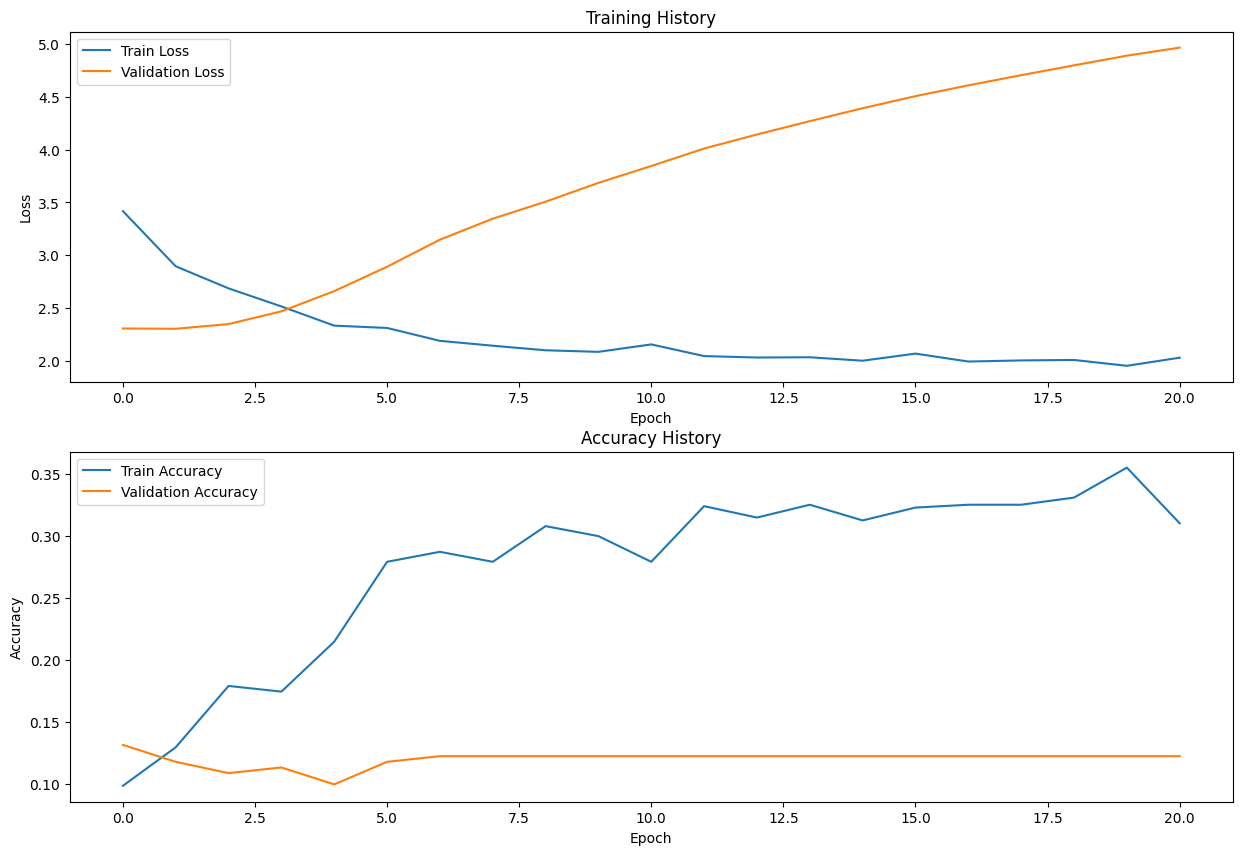

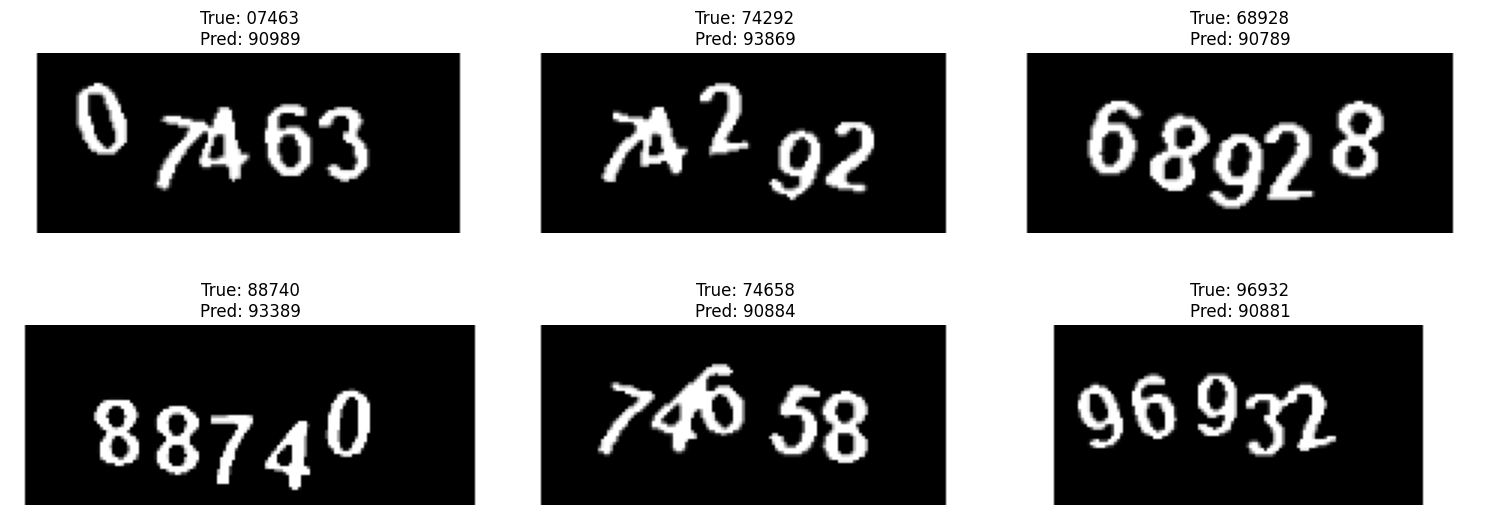


Sample Predictions:
True: 50377, Predicted: 23706
True: 96932, Predicted: 90881
True: 67808, Predicted: 20798
True: 85609, Predicted: 93789
True: 07463, Predicted: 90989
True: 74658, Predicted: 90884
True: 80200, Predicted: 73286
True: 42397, Predicted: 13787
True: 94399, Predicted: 93206
True: 68928, Predicted: 90789
True: 88740, Predicted: 93389
True: 23065, Predicted: 60804
True: 96620, Predicted: 93819
True: 06036, Predicted: 26289
True: 40208, Predicted: 93884
True: 85070, Predicted: 63289
True: 82707, Predicted: 20789
True: 08566, Predicted: 63786
True: 74698, Predicted: 90588
True: 40059, Predicted: 90584


In [11]:
import os
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

# Configuration - using your actual image size
IMG_WIDTH = 160
IMG_HEIGHT = 60
BATCH_SIZE = 32
EPOCHS = 150  # Increased epochs for better convergence
CHARACTERS = '0123456789'
NUM_CLASSES = len(CHARACTERS)
MAX_LENGTH = 5
DATA_DIR = path

# 1. Data Loading and Preprocessing
def clean_filename(filename):
    """Extract only the numeric part from filename"""
    filename = os.path.splitext(filename)[0]
    digits = re.sub(r'\D', '', filename)
    return digits[:5] if len(digits) >= 5 else None

def load_data(data_dir):
    images = []
    labels = []
    
    for filename in os.listdir(data_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            clean_label = clean_filename(filename)
            if clean_label is None or len(clean_label) != 5:
                continue
                
            img_path = os.path.join(data_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
                
            # Resize to target dimensions
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img / 255.0
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            
            images.append(img)
            labels.append(clean_label)
    
    print(f"Loaded {len(images)} valid CAPTCHA images")
    return np.array(images), labels

def encode_labels(labels):
    char_to_num = {char: idx for idx, char in enumerate(CHARACTERS)}
    encoded_labels = []
    
    for label in labels:
        try:
            encoded_label = [char_to_num[char] for char in label]
            encoded_labels.append(encoded_label)
        except KeyError:
            continue
    
    return np.array(encoded_labels)

# 2. Enhanced Model Architecture (Single Output with Positional Decoding)
def build_cnn_model():
    input_img = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction
    x = layers.Conv2D(32, (3, 3), padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Flatten and add dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Output layer - 5 digits * 10 classes
    output = layers.Dense(MAX_LENGTH * NUM_CLASSES, activation='softmax')(x)
    output = layers.Reshape((MAX_LENGTH, NUM_CLASSES))(output)
    
    return models.Model(inputs=input_img, outputs=output)

# 3. Training and Evaluation
def train_model(images, encoded_labels):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        images, encoded_labels, test_size=0.2, random_state=42)
    
    # Convert labels to categorical format
    y_train_cat = [tf.keras.utils.to_categorical(y_train[:, i], num_classes=NUM_CLASSES) 
                   for i in range(MAX_LENGTH)]
    y_test_cat = [tf.keras.utils.to_categorical(y_test[:, i], num_classes=NUM_CLASSES) 
                  for i in range(MAX_LENGTH)]
    
    # Combine labels for single output
    y_train_combined = np.stack(y_train_cat, axis=1)
    y_test_combined = np.stack(y_test_cat, axis=1)
    
    # Build model
    model = build_cnn_model()
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True, monitor='val_accuracy'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
        ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy')
    ]
    
    # Train model
    history = model.fit(
        X_train, y_train_combined,
        validation_data=(X_test, y_test_combined),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history, X_test, y_test

# 4. Evaluation and Prediction
def decode_predictions(preds):
    """Decode model predictions to text"""
    decoded_texts = []
    for pred in preds:
        text = ''
        for digit_pred in pred:
            digit = np.argmax(digit_pred)
            text += CHARACTERS[digit]
        decoded_texts.append(text)
    return decoded_texts

def calculate_accuracy(model, X_test, y_test):
    # Make predictions
    preds = model.predict(X_test)
    decoded_preds = decode_predictions(preds)
    
    # Convert true labels to text
    true_texts = []
    for label in y_test:
        text = ''.join(CHARACTERS[digit] for digit in label)
        true_texts.append(text)
    
    # Calculate accuracy
    correct = sum(1 for true, pred in zip(true_texts, decoded_preds) if true == pred)
    accuracy = correct / len(true_texts)
    return accuracy, true_texts, decoded_preds

# 5. Visualization
def plot_results(history, X_test, true_texts, decoded_preds):
    plt.figure(figsize=(15, 10))
    
    # Plot training history
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot sample predictions
    plt.figure(figsize=(15, 6))
    sample_indices = np.random.choice(len(X_test), size=min(6, len(X_test)), replace=False)
    for i, idx in enumerate(sample_indices):
        plt.subplot(2, 3, i+1)
        plt.imshow(X_test[idx].squeeze(), cmap='gray')
        plt.title(f"True: {true_texts[idx]}\nPred: {decoded_preds[idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main Execution
if __name__ == "__main__":
    print("Loading data...")
    images, labels = load_data(DATA_DIR)
    print(f"Sample image shape: {images[0].shape} (height, width, channels)")
    
    encoded_labels = encode_labels(labels)
    print(f"Encoded labels shape: {encoded_labels.shape}")
    print(f"Sample label: {labels[0]} -> Encoded: {encoded_labels[0]}")
    
    print("\nTraining model...")
    model, history, X_test, y_test = train_model(images, encoded_labels)
    
    print("\nEvaluating...")
    accuracy, true_texts, decoded_preds = calculate_accuracy(model, X_test, y_test)
    print(f"\nOverall Test Accuracy: {accuracy * 100:.2f}%")
    
    # Print position-wise accuracy
    position_acc = []
    for i in range(MAX_LENGTH):
        correct = 0
        for true, pred in zip(true_texts, decoded_preds):
            if true[i] == pred[i]:
                correct += 1
        position_acc.append(correct / len(true_texts))
        print(f"Position {i+1} Accuracy: {position_acc[-1] * 100:.2f}%")
    
    # Visualize results
    plot_results(history, X_test, true_texts, decoded_preds)
    
    # Print sample predictions
    print("\nSample Predictions:")
    for i in range(min(20, len(true_texts))):
        print(f"True: {true_texts[i]}, Predicted: {decoded_preds[i]}")

Loading data...
Loaded 218 valid CAPTCHA images
Sample image shape: (60, 160, 1) (height, width, channels)
Encoded labels shape: (218, 5)
Sample label: 00688 -> Encoded: [0 0 6 8 8]

Training model...
Epoch 1/100
6/6 [==============================] - 30s 3s/step - loss: 221.0511 - val_loss: 253.7640 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 11s 2s/step - loss: 182.0197 - val_loss: 206.0415 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 11s 2s/step - loss: 160.4611 - val_loss: 155.7304 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 12s 2s/step - loss: 90.3716 - val_loss: 21.5687 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 12s 2s/step - loss: 16.8313 - val_loss: 14.0076 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 12s 2s/step - loss: 17.3421 - val_loss: 14.8517 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 12s 2s/step - loss: 16.9245 - val_loss: 13.8834 - lr: 0.0010
Epoch 8/1

C:\Users\adity\AppData\Local\Temp\ipykernel_26516\856786092.py:225: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i+1)


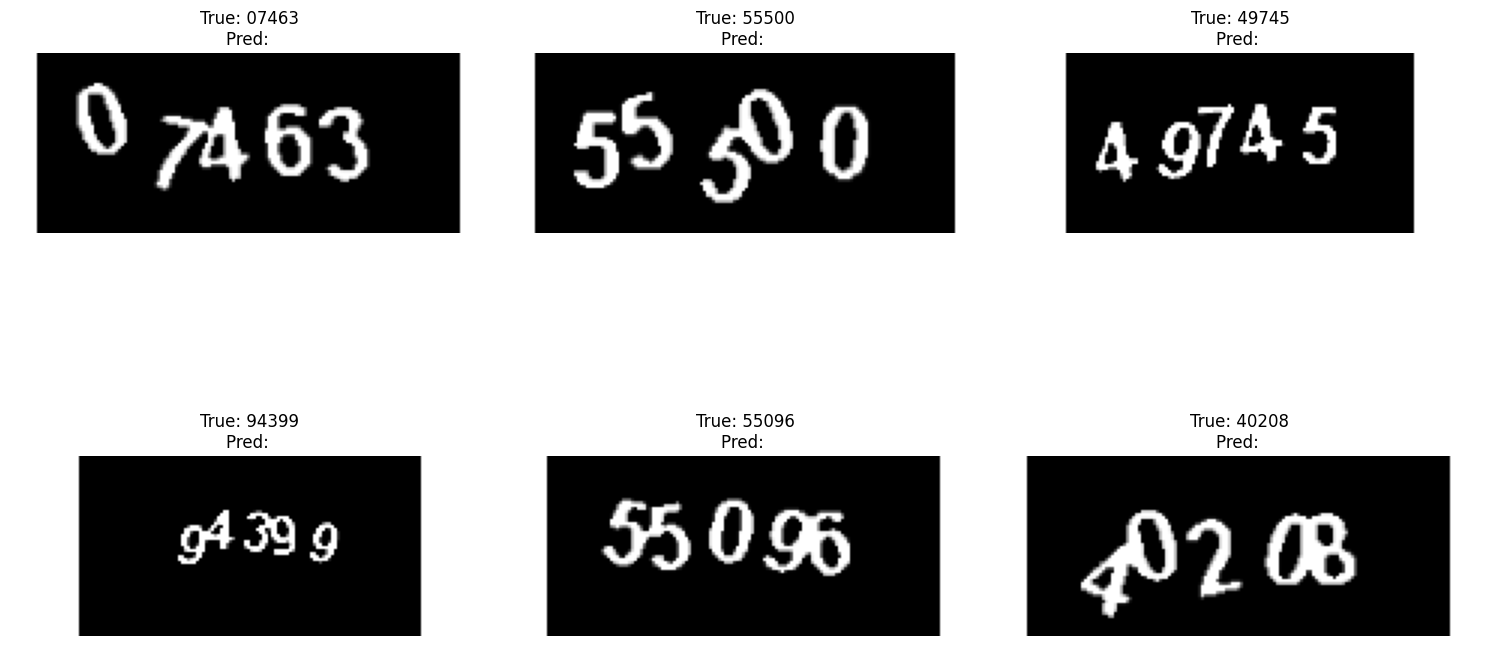


Sample Predictions:
True: 50377, Predicted: 
True: 96932, Predicted: 
True: 67808, Predicted: 
True: 85609, Predicted: 
True: 07463, Predicted: 
True: 74658, Predicted: 
True: 80200, Predicted: 
True: 42397, Predicted: 
True: 94399, Predicted: 
True: 68928, Predicted: 
True: 88740, Predicted: 
True: 23065, Predicted: 
True: 96620, Predicted: 
True: 06036, Predicted: 
True: 40208, Predicted: 
True: 85070, Predicted: 
True: 82707, Predicted: 
True: 08566, Predicted: 
True: 74698, Predicted: 
True: 40059, Predicted: 


In [14]:
import os
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Configuration
IMG_WIDTH = 160
IMG_HEIGHT = 60
BATCH_SIZE = 32
EPOCHS = 100
CHARACTERS = '0123456789'
NUM_CLASSES = len(CHARACTERS) + 1  # +1 for CTC blank token
MAX_LENGTH = 5
DATA_DIR = path

# 1. Data Loading and Preprocessing
def clean_filename(filename):
    """Extract only the numeric part from filename"""
    filename = os.path.splitext(filename)[0]
    digits = re.sub(r'\D', '', filename)
    return digits[:5] if len(digits) >= 5 else None

def load_data(data_dir):
    images = []
    labels = []
    
    for filename in os.listdir(data_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            clean_label = clean_filename(filename)
            if clean_label is None or len(clean_label) != 5:
                continue
                
            img_path = os.path.join(data_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
                
            # Resize to target dimensions
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img / 255.0
            img = np.expand_dims(img, axis=-1)
            
            images.append(img)
            labels.append(clean_label)
    
    print(f"Loaded {len(images)} valid CAPTCHA images")
    return np.array(images), labels

def encode_labels(labels):
    char_to_num = {char: idx for idx, char in enumerate(CHARACTERS)}
    encoded_labels = []
    
    for label in labels:
        try:
            encoded_label = [char_to_num[char] for char in label]
            encoded_labels.append(encoded_label)
        except KeyError:
            continue
    
    return np.array(encoded_labels)

# 2. CRNN Model with CTC Loss
def ctc_loss(args):
    y_true, y_pred = args
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

def build_crnn_model():
    # Input layer
    input_img = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name='image')
    
    # CNN Feature Extractor
    x = layers.Conv2D(32, (3, 3), padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Calculate feature map dimensions after convolutions
    conv_output_shape = x.shape
    timesteps = conv_output_shape[1] * conv_output_shape[2]  # Width * Height
    features = conv_output_shape[3]  # Channels
    
    # Reshape for RNN (timesteps, features)
    x = layers.Reshape((timesteps, features))(x)
    
    # RNN Sequence Processing
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    
    # Output layer
    output = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return models.Model(inputs=input_img, outputs=output)

def build_final_model(crnn_model):
    # Input layers
    input_img = crnn_model.input
    labels = layers.Input(name='label', shape=[MAX_LENGTH], dtype='int32')
    
    # Output from CRNN model
    output = crnn_model.output
    
    # CTC loss
    loss_out = layers.Lambda(ctc_loss, output_shape=(1,), name='ctc')([labels, output])
    
    # Final model
    return models.Model(inputs=[input_img, labels], outputs=loss_out)

# 3. Training and Evaluation
def train_model(images, encoded_labels):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        images, encoded_labels, test_size=0.2, random_state=42)
    
    # Build models
    crnn_model = build_crnn_model()
    model = build_final_model(crnn_model)
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={'ctc': lambda y_true, y_pred: y_pred}
    )
    
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
        ModelCheckpoint('crnn_model.h5', save_best_only=True, monitor='val_loss')
    ]
    
    # Train model
    history = model.fit(
        [X_train, y_train], 
        np.zeros((len(X_train), 1)),
        validation_data=(
            [X_test, y_test], 
            np.zeros((len(X_test), 1))
        ),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    
    return crnn_model, history, X_test, y_test

def decode_predictions(preds):
    """Decode model predictions using CTC beam search"""
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    decoded, _ = K.ctc_decode(
        preds, 
        input_length=input_len,
        greedy=False,
        beam_width=10,
        top_paths=1
    )
    decoded = decoded[0].numpy()
    
    decoded_texts = []
    for sequence in decoded:
        text = ''
        for char_idx in sequence:
            if char_idx == -1:  # Padding
                break
            if char_idx < len(CHARACTERS):
                text += CHARACTERS[char_idx]
        decoded_texts.append(text)
    return decoded_texts

def calculate_accuracy(model, X_test, y_test):
    # Make predictions
    preds = model.predict(X_test)
    
    # Decode predictions
    decoded_preds = decode_predictions(preds)
    
    # Convert true labels to text
    true_texts = []
    for label in y_test:
        text = ''.join(CHARACTERS[digit] for digit in label)
        true_texts.append(text)
    
    # Calculate accuracy
    correct = sum(1 for true, pred in zip(true_texts, decoded_preds) if true == pred)
    accuracy = correct / len(true_texts)
    return accuracy, true_texts, decoded_preds

# 4. Visualization
def plot_results(history, X_test, true_texts, decoded_preds):
    plt.figure(figsize=(15, 10))
    
    # Plot training history
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot sample predictions
    plt.subplot(2, 1, 2)
    sample_indices = np.random.choice(len(X_test), size=min(6, len(X_test)), replace=False)
    for i, idx in enumerate(sample_indices):
        plt.subplot(2, 3, i+1)
        plt.imshow(X_test[idx].squeeze(), cmap='gray')
        plt.title(f"True: {true_texts[idx]}\nPred: {decoded_preds[idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main Execution
if __name__ == "__main__":
    print("Loading data...")
    images, labels = load_data(DATA_DIR)
    print(f"Sample image shape: {images[0].shape} (height, width, channels)")
    
    encoded_labels = encode_labels(labels)
    print(f"Encoded labels shape: {encoded_labels.shape}")
    print(f"Sample label: {labels[0]} -> Encoded: {encoded_labels[0]}")
    
    print("\nTraining model...")
    model, history, X_test, y_test = train_model(images, encoded_labels)
    
    print("\nEvaluating...")
    accuracy, true_texts, decoded_preds = calculate_accuracy(model, X_test, y_test)
    print(f"\nOverall Test Accuracy: {accuracy * 100:.2f}%")
    
    # Print position-wise accuracy
    position_acc = []
    for i in range(MAX_LENGTH):
        correct = 0
        for true, pred in zip(true_texts, decoded_preds):
            if i < len(true) and i < len(pred) and true[i] == pred[i]:
                correct += 1
        position_acc.append(correct / len(true_texts))
        print(f"Position {i+1} Accuracy: {position_acc[-1] * 100:.2f}%")
    
    # Visualize results
    plot_results(history, X_test, true_texts, decoded_preds)
    
    # Print sample predictions
    print("\nSample Predictions:")
    for i in range(min(20, len(true_texts))):
        print(f"True: {true_texts[i]}, Predicted: {decoded_preds[i]}")

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

# Set constants
CAPTCHA_LENGTH = 5
CHARACTERS = list("0123456789")
IMG_WIDTH, IMG_HEIGHT = 160, 60
BATCH_SIZE = 32
EPOCHS = 100  # Increased for better convergence

# Create character mappings
char_to_num = layers.StringLookup(vocabulary=CHARACTERS, mask_token=None)
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    invert=True,
    mask_token=None
)

# Load images and labels
def load_data(img_dir):
    images = []
    labels = []
    for f in os.listdir(img_dir):
        if f.endswith(".png"):
            label = os.path.splitext(f)[0]
            img_path = os.path.join(img_dir, f)
            img = Image.open(img_path).convert("L").resize((IMG_WIDTH, IMG_HEIGHT))
            img_array = np.array(img) / 255.0
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Encode labels as integer tensors
def encode_labels(labels):
    encoded = []
    for label in labels:
        # Split string into characters and convert to tensor
        chars = tf.strings.unicode_split(label, input_encoding="UTF-8")
        encoded.append(char_to_num(chars))
    # Pad sequences to fixed length
    return tf.keras.preprocessing.sequence.pad_sequences(
        encoded, maxlen=CAPTCHA_LENGTH, padding='post', value=0
    )

# Prepare data - replace 'path' with your actual image directory
images, labels = load_data(path)
labels_encoded = encode_labels(labels)
images = np.expand_dims(images, axis=-1)  # Add channel dimension

# Split data
x_train, x_val, y_train, y_val = train_test_split(
    images, labels_encoded, test_size=0.2, random_state=42
)

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Model architecture
def build_model():
    input_img = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name="image")
    
    # Feature extraction
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Calculate new shape after convolutions
    conv_shape = x.shape
    timesteps = conv_shape[1] * conv_shape[2]  # Width * height
    features = conv_shape[3]
    
    # Reshape for sequence processing
    x = layers.Reshape(target_shape=(timesteps, features))(x)
    
    # Sequence processing
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer
    output = layers.Dense(len(CHARACTERS) + 1, activation="softmax")(x)
    
    model = keras.models.Model(inputs=input_img, outputs=output, name="captcha_ocr_model")
    return model

model = build_model()
model.summary()

# CTC Loss function
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    return keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=ctc_loss
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(
        "captcha_model_best.h5", 
        save_best_only=True,
        monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.2, 
        patience=5,
        min_lr=1e-6
    )
]

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save final model
model.save("captcha_model_final.h5")

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

# Decode predictions
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(
        pred, 
        input_length=input_len,
        greedy=True,
        beam_width=10,
        top_paths=1
    )[0][0]
    
    output_text = []
    for res in results:
        # Convert to string and remove padding
        decoded = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        # Remove CTC blank tokens
        decoded = decoded.replace('[UNK]', '').replace(' ', '')
        output_text.append(decoded)
    return output_text

# Evaluate accuracy
def evaluate(model, dataset):
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for batch_images, batch_labels in dataset:
        preds = model.predict(batch_images, verbose=0)
        pred_texts = decode_batch_predictions(preds)

        true_texts = []
        for label_seq in batch_labels:
            label_str = tf.strings.reduce_join(num_to_char(label_seq)).numpy().decode("utf-8")
            true_texts.append(label_str)

        for pred, true in zip(pred_texts, true_texts):
            if pred == true:
                correct += 1
            total += 1
            all_preds.append(pred)
            all_labels.append(true)

    acc = correct / total
    print(f"Validation accuracy: {acc:.4f}")
    
    # Print sample predictions
    print("\nSample Predictions:")
    for i in range(min(15, len(all_labels))):
        print(f"True: {all_labels[i]}, Predicted: {all_preds[i]}")
    
    return acc

# Run evaluation
print("\nEvaluating model...")
accuracy = evaluate(model, val_ds)
print(f"Final Accuracy: {accuracy*100:.2f}%")

Model: "captcha_ocr_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 60, 160, 1)]      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 60, 160, 32)       320       
                                                                 
 batch_normalization_25 (Bat  (None, 60, 160, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 30, 80, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 30, 80, 64)        18496     
                                                                 
 batch_normalization_26 (Bat  (None, 30, 80, 64) 

InvalidArgumentError: Graph execution error:

Detected at node 'ctc_loss/CTCLoss' defined at (most recent call last):
    File "c:\Users\adity\.conda\envs\captchaenv\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\adity\.conda\envs\captchaenv\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\adity\.conda\envs\captchaenv\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\adity\.conda\envs\captchaenv\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\adity\.conda\envs\captchaenv\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\adity\AppData\Local\Temp\ipykernel_26516\2212750893.py", line 142, in <module>
      history = model.fit(
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\adity\AppData\Local\Temp\ipykernel_26516\2212750893.py", line 117, in ctc_loss
      return keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    File "c:\Users\adity\.conda\envs\captchaenv\lib\site-packages\keras\backend.py", line 7020, in ctc_batch_cost
      tf.compat.v1.nn.ctc_loss(
Node: 'ctc_loss/CTCLoss'
Saw a non-null label (index >= num_classes - 1) following a null label, batch: 0 num_classes: 11 labels: 8,10,1,9,9 labels seen so far: 8
	 [[{{node ctc_loss/CTCLoss}}]] [Op:__inference_train_function_227551]